## <font color='darkblue'>Preface</font>
([article source](https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/)) <font size='3ptx'><b>"If 80 percent of our work is data preparation, then ensuring data quality is the important work of a machine learning team.” - – Andrew Ng</b> Feature engineering is one of the most important steps in machine learning. It is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Think machine learning algorithm as a learning child the more accurate information you provide the more they will be able to interpret the information well. Focusing first on our data will give us better results than focusing only on models. Feature engineering helps us to create better data which helps the model understand it well and provide reasonable results.</font>

<b>NLP is a subfield of artificial intelligence where we understand human interaction with machines using natural languages</b>. To understand a natural language, you need to understand how we write a sentence, how we express our thoughts using different words, signs, special characters, etc basically we should understand the context of the sentence to interpret its meaning.

<b>If we can use these contexts as features and feed them to our model then the model will be able to understand the sentence better</b>. Some of the common features that we can extract from a sentence are the number of words, number of capital words, number of punctuation, number of unique words, number of stopwords, average sentence length, etc. We can define these features based on our data set we are using. In this blog, we will use a Twitter data set so we can add some others features like the number of hashtags, number of mentions, etc. We will discuss them in detail in the coming sections.

<a id='sect0'></a>
### <font color='darkgreen'>Table of Content</font>
* <font size='3ptx'><b><a href='#sect1'>NLP task overview</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>List of features with code</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Implementation</a></b></font>
* <font size='3ptx'><b><a href='#sect4'>Results comparison with and without doing feature engineering</a></b></font>
* <font size='3ptx'><b><a href='#sect5'>Conclusion</a></b></font>

In [1]:
import pandas as pd
import seaborn as sns
import re
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
#nltk.download('stopwords')
#nltk.download('punkt')

In [3]:
RANDOM_STATE = 42

<a id='sect1'></a>
## <font color='darkblue'>NLP task overview</font>
<font size='3ptx'><b>To understand the feature engineering task in NLP, we will be implementing it on a Twitter dataset</b>. We will be using COVID-19 Fake News Dataset. The task is to classify the tweet as Fake or Real.</font>

You can download the dataset from [here](https://www.kaggle.com/datasets/arashnic/covid19-fake-news?resource=download) (or [here](https://github.com/MiHarsh/Public_stuffs)). The dataset is divided into train, validation, and test set.  Below is the distribution,

In [4]:
train_df = pd.read_csv('https://raw.githubusercontent.com/MiHarsh/Public_stuffs/master/Constraint_English_Train%20-%20Sheet1.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/MiHarsh/Public_stuffs/master/Constraint_English_Val%20-%20Sheet1.csv')

In [5]:
print(train_df.shape)
train_df.sample(n=3)

(6420, 3)


,id,tweet,label
5180,5181,Demanding a fair Probe #JusticforTarun.(1)..Wh...,fake
1599,1600,@myjourneymyself Dr. Fauci funded a risky ''ga...,fake
4326,4327,Consuming a cup of brown sugar per day can cur...,fake


In [6]:
test_df.sample(n=3)

,id,tweet,label
573,574,MLB Commissioner Rob Manfred Says That the Wee...,fake
290,291,A Facebook post claims a drug company whistleb...,fake
1585,1586,States reported 42k new cases today. The five ...,real


Below is the distribution:

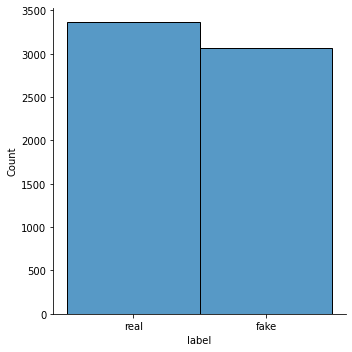

In [7]:
# training data
sns.displot(train_df, x="label")

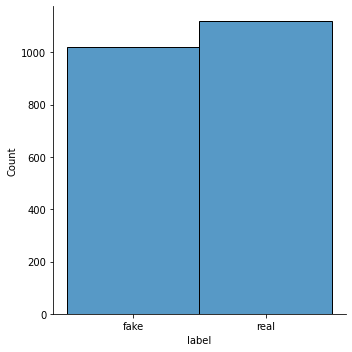

In [8]:
# testing data
sns.displot(test_df, x="label")

<a id='sect2'></a>
## <font color='darkblue'>List of features</font> ([back](#sect0))
I will be listing out a total of 15 features that we can use for the above dataset, number of features totally depends upon the type of dataset you are using.

#### 1. Number of Characters
Count the number of characters present in a tweet.

In [9]:
def count_chars(text):
    return len(text)

#### 2. Number of words
Count the number of words present in a tweet.

In [10]:
def count_words(text):
    return len(text.split())

#### 3. Number of capital characters
Count the number of capital characters present in a tweet.

In [11]:
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

#### 4. Number of capital words
Count the number of capital words present in a tweet.

In [12]:
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

#### 5. Count the number of punctuations
In this function, we return a dictionary of 32 punctuation with the counts, which can be used as separate features, which I will discuss in the next section.

In [13]:
def count_punctuations(text):
    punctuations='!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

#### 6. Number of words in quotes
The number of words in the single quotation and double quotation.

In [14]:
def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

#### 7. Number of sentences
Count the number of sentences in a tweet.

In [15]:
def count_sent(text):
    return len(nltk.sent_tokenize(text))

#### 8. Count the number of unique words
Count the number of unique words in a tweet.

In [16]:
def count_unique_words(text):
    return len(set(text.split()))

#### 9. Count of hashtags
Since we are using the Twitter dataset we can count the number of times users used the hashtag.

In [17]:
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

#### 10. Count of mentions
On Twitter, most of the time people reply or mention someone in their tweet, counting the number of mentions can also be treated as a feature.

In [18]:
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

#### 11. Count of stopwords
Here we will count the number of stopwords used in a tweet.

In [19]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

#### 12. Calculating average word length
This can be calculated by dividing the counts of characters by counts of words.
```python
train_df['avg_wordlength'] = train_df['char_count']/train_df['word_count']
```

#### 13. Calculating average sentence length
This can be calculated by dividing the counts of words by the counts of sentences.
```python
train_df['avg_sentlength'] = train_df['word_count']/train_df['sent_count']
```

#### 14. unique words vs word count feature
This feature is basically the ratio of unique words to a total number of words.
```python
df['unique_vs_words'] = df['unique_word_count']/df['word_count']
```

#### 15. Stopwords count vs words counts feature
This feature is also the ratio of counts of stopwords to the total number of words.
```python
df['stopwords_vs_words'] = df['stopword_count']/df['word_count']
```

<a id='sect3'></a>
## <font color='darkblue'>Implementation</font> ([back](#sect0))
We will focus more on feature engineering, for this we will keep the approach simple, by using TF-IDF and simple pre-processing. All the code will be available on my GitHub repository https://github.com/ahmadkhan242/Feature-Engineering-in-NLP.

### <font color='darkgreen'>Applying the above-defined feature extraction on train and test set</font>

In [20]:
def gen_features(df):
    df['char_count'] = df["tweet"].apply(lambda x:count_chars(x))
    df['word_count'] = df["tweet"].apply(lambda x:count_words(x))
    df['sent_count'] = df["tweet"].apply(lambda x:count_sent(x))
    df['capital_char_count'] = df["tweet"].apply(lambda x:count_capital_chars(x))
    df['capital_word_count'] = df["tweet"].apply(lambda x:count_capital_words(x))
    df['quoted_word_count'] = df["tweet"].apply(lambda x:count_words_in_quotes(x))
    df['stopword_count'] = df["tweet"].apply(lambda x:count_stopwords(x))
    df['unique_word_count'] = df["tweet"].apply(lambda x:count_unique_words(x))
    df['htag_count'] = df["tweet"].apply(lambda x:count_htags(x))
    df['mention_count'] = df["tweet"].apply(lambda x:count_mentions(x))
    df['punct_count'] = df["tweet"].apply(lambda x:count_punctuations(x))
    df['avg_wordlength'] = df['char_count']/df['word_count']
    df['avg_sentlength'] = df['word_count']/df['sent_count']
    df['unique_vs_words'] = df['unique_word_count']/df['word_count']
    df['stopwords_vs_words'] = df['stopword_count']/df['word_count']
    return df

In [21]:
train_df = gen_features(train_df)
test_df = gen_features(test_df)

In [22]:
train_df.sample(n=3)

,id,tweet,label,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
2158,2159,"Orwell not dead, but living under a bridge (co...",fake,130,14,1,5,0,0,4,14,0,0,"{'! count': 0, '"" count': 0, '# count': 4, '$ ...",9.285714,14.0,1.000000,0.285714
5871,5872,The Governor of Maine has ordered restaurant s...,fake,130,20,1,8,1,0,6,20,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",6.500000,20.0,1.000000,0.300000
4240,4241,The media ???pulled down an entire shelf of go...,fake,143,26,2,1,0,0,13,24,0,0,"{'! count': 0, '"" count': 1, '# count': 0, '$ ...",5.500000,13.0,0.923077,0.500000


### <font color='darkgreen'>Adding some extra features using punctuation count</font>
We will create a DataFrame from the dictionary returned by the “punct_count” function and then merge it with the main dataset.

In [23]:
test_punct_df = pd.DataFrame(list(test_df.punct_count))
train_punct_df = pd.DataFrame(list(train_df.punct_count))
train_punct_df.head(n=3)

,! count,""" count",# count,$ count,% count,& count,' count,( count,) count,* count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Merging pnctuation DataFrame with main DataFrame
train_df = pd.merge(train_df, train_punct_df, left_index=True, right_index=True)
test_df = pd.merge(test_df, test_punct_df, left_index=True, right_index=True)
train_df.sample(n=3)

,id,tweet,label,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
5433,5434,Youth and summer camp administrators: CDC has ...,real,288,40,4,21,2,0,12,...,0,0,0,0,0,0,0,0,0,0
4857,4858,First coronavirus reinfection reported in the ...,real,186,26,3,10,1,0,8,...,0,0,0,0,0,0,0,0,0,0
5496,5497,Italian doctors have confirmed that COVID-19 i...,fake,132,23,1,6,1,0,12,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# We can drop "punct_count" column from both df and test DataFrame
train_df.drop(columns=['punct_count'], inplace=True)
test_df.drop(columns=['punct_count'], inplace=True)
train_df.columns

Index(['id', 'tweet', 'label', 'char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count'],
      dtype='object')

### <font color='darkgreen'>Re-processing</font>
We performed a simple pre-processing step, like removing links, removing user name, numbers, double space, punctuation, lower casing, etc.

In [26]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'httpS+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RTs@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

my_punctuation = '!"$%&\'()*+,-./:;<=>?[\]^_`{|}~•@'
    
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+my_punctuation + ']+', ' ', sent) # strip punctuation
    sent = re.sub('s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent

train_df['tweet']   = train_df['tweet'].apply(lambda x: preprocess(x))
test_df['tweet'] = test_df['tweet'].apply(lambda x: preprocess(x))

In [27]:
train_df.columns

Index(['id', 'tweet', 'label', 'char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count'],
      dtype='object')

### <font color='darkgreen'>Encoding text</font>
We will encode our text data using TF-IDF. We first fit transform on our train and test set’s tweet column and then merge it with all features columns.

In [28]:
vectorizer            =  TfidfVectorizer()
train_tf_idf_features =  vectorizer.fit_transform(train_df['tweet']).toarray()
test_tf_idf_features  =  vectorizer.transform(test_df['tweet']).toarray()

# Converting above list to DataFrame
train_tf_idf_df          = pd.DataFrame(train_tf_idf_features)
test_tf_idf_df           = pd.DataFrame(test_tf_idf_features)

# Saparating train and test labels from all features
y_train               = train_df['label']
y_test                = test_df['label']

#Listing all features
features = ['char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '\' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count']

# Finally merging all features with above TF-IDF. 
X_train = pd.merge(train_tf_idf_df, train_df[features], left_index=True, right_index=True)
X_test  = pd.merge(test_tf_idf_df, test_df[features], left_index=True, right_index=True)

In [29]:
X_train.sample(n=3)

,0,1,2,3,4,5,6,7,8,9,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
5513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### <font color='darkgreen'>Training</font>
For training, we will be using the Random forest algorithm ([**RandomForestClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) from the sci-kit learn library.

In [30]:
%%time
clf_model = RandomForestClassifier(
    n_estimators = 1000, min_samples_split = 15, random_state = RANDOM_STATE)
clf_model.fit(X_train, y_train)

/root/Github/ml_courses/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


CPU times: user 2min 2s, sys: 194 ms, total: 2min 3s
Wall time: 2min 3s


RandomForestClassifier(min_samples_split=15, n_estimators=1000, random_state=42)

In [31]:
y_pred = clf_model.predict(X_test)

/root/Github/ml_courses/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [32]:
y_pred[:10]

array(['fake', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real',
       'fake', 'fake'], dtype=object)

In [33]:
print(f'Accuracy: {accuracy_score(y_test, y_pred):.01%}')
print()
print(classification_report(y_test, y_pred))

Accuracy: 93.4%

              precision    recall  f1-score   support

        fake       0.97      0.89      0.93      1020
        real       0.91      0.97      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.94      0.93      0.93      2140
weighted avg       0.94      0.93      0.93      2140



<a id='sect4'></a>
## <font color='darkblue'>Result comparison</font> ([back](#sect0))
* <font size='3ptx'><b><a href='#sect4_1'>Without using Feature Engineering techniques</a></b></font>
* <font size='3ptx'><b><a href='#sect4_2'>Using Feature Engineering techniques</a></b></font>
<br/>

<font size='3ptx'><b>For comparison, we first trained our model on the above dataset by using features engineering techniques and then without using feature engineering techniques</b></font>.

In both approaches, we pre-processed the dataset using the same method as described above and TF-IDF was used in both approaches for encoding the text data. You can use whatever encoding techniques you want to use like word2vec, glove, etc.

In [34]:
perf_data = []

In [35]:
def insert_perf_data(y_pred, name, feature_size):
    y_test_binary = [1 if label=='fake' else 0 for label in y_test]
    y_pred_binary = [1 if label=='fake' else 0 for label in y_pred]
    accuracy = accuracy_score(y_test, y_pred)
    perf_data.append((
        name,
        feature_size,
        accuracy,
        recall_score(y_test_binary, y_pred_binary),
        precision_score(y_test_binary, y_pred_binary),
        f1_score(y_test_binary, y_pred_binary)))

    print(f'Accuracy: {accuracy:.01%}')
    print(classification_report(y_test, y_pred))
    return perf_data[-1]

<a id='sect4_1'></a>
### <font color='darkgreen'>Without using Feature Engineering techniques</font>
Here we only use features tf-idf:

In [36]:
%%time
clf_model = RandomForestClassifier(
    n_estimators = 1000, min_samples_split = 15, random_state = RANDOM_STATE)
clf_model.fit(train_tf_idf_features, y_train)

CPU times: user 9min 31s, sys: 159 ms, total: 9min 31s
Wall time: 9min 31s


RandomForestClassifier(min_samples_split=15, n_estimators=1000, random_state=42)

In [37]:
y_pred = clf_model.predict(test_tf_idf_features)

In [38]:
insert_perf_data(y_pred, 'tf-idf', train_tf_idf_features.shape[1])

Accuracy: 91.2%
              precision    recall  f1-score   support

        fake       0.94      0.87      0.90      1020
        real       0.89      0.95      0.92      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



('tf-idf',
 13872,
 0.9121495327102803,
 0.8745098039215686,
 0.9369747899159664,
 0.9046653144016227)

<a id='sect4_2'></a>
### <font color='darkgreen'>Using Feature Engineering techniques</font>
Here we used up all features we have:

In [39]:
%%time
clf_model = RandomForestClassifier(
    n_estimators = 1000, min_samples_split = 15, random_state = RANDOM_STATE)
clf_model.fit(X_train, y_train)

/root/Github/ml_courses/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


CPU times: user 2min 2s, sys: 264 ms, total: 2min 2s
Wall time: 2min 2s


RandomForestClassifier(min_samples_split=15, n_estimators=1000, random_state=42)

In [40]:
y_pred = clf_model.predict(X_test)

/root/Github/ml_courses/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [41]:
insert_perf_data(y_pred, 'tf-idf + feature engineering', X_train.shape[1])

Accuracy: 93.4%
              precision    recall  f1-score   support

        fake       0.97      0.89      0.93      1020
        real       0.91      0.97      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.94      0.93      0.93      2140
weighted avg       0.94      0.93      0.93      2140



('tf-idf + feature engineering',
 13918,
 0.9336448598130841,
 0.8911764705882353,
 0.9670212765957447,
 0.9275510204081633)

### <font color='darkgreen'>Replace tf-idf with word-vector</font>

Here we use [**word2vec**](https://en.wikipedia.org/wiki/Word2vec) to replace tf-idf:

In [42]:
#!pip3 install gensim
test_tf_idf_features = train_tf_idf_features = None

In [43]:
import gensim.downloader as api
from gensim.models import Word2Vec

In [44]:
w2v_feature_names = [f'w{i}' for i in range(300)]

def text2w2v(df, column='tweet'):
    model = api.load("word2vec-google-news-300") 
    wv_list = []
    for ri, row in df.iterrows():
        vector = np.zeros(300)
        for w in row.get(column).split():
            try:
                vector += model[w]
            except Exception as e:
                pass
            
        wv_list.append(vector)
        
    w2v_df = pd.DataFrame(wv_list, columns=[f'w{i}' for i in range(300)])
    df = pd.concat([df, w2v_df], axis=1)
    return df

In [45]:
%%time
train_df = text2w2v(train_df)

CPU times: user 31.3 s, sys: 59.4 s, total: 1min 30s
Wall time: 1min 31s


In [46]:
%%time
test_df = text2w2v(test_df)

CPU times: user 52.5 s, sys: 1.25 s, total: 53.8 s
Wall time: 54 s


In [47]:
print(train_df.shape)
train_df.sample(n=3)

(6420, 349)


,id,tweet,label,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,w290,w291,w292,w293,w294,w295,w296,w297,w298,w299
3785,3786,rt in a uo moto tatement in #lok abha on #...,real,138,19,1,20,3,0,5,...,-0.143005,0.065186,-0.672852,0.352051,0.093506,-0.524475,-0.694763,0.398315,-1.125122,0.199860
4477,4478,new rule banning ocial gathering of more th...,real,218,39,3,5,0,0,18,...,-0.912689,1.234344,-1.290840,-0.918701,-1.965206,-1.078857,0.563293,-1.158279,1.134354,0.016987
3859,3860,rt if you have recovered from #covid confirm...,real,138,23,2,13,2,0,7,...,-0.746460,0.267296,-1.561256,0.951660,0.596375,-0.697601,-0.319214,-2.548584,-0.775101,0.031555


In [48]:
X_train = train_df[features + w2v_feature_names]
X_test  = test_df[features + w2v_feature_names]

In [49]:
%%time
clf_model = RandomForestClassifier(
    n_estimators = 1000, min_samples_split = 15, random_state = RANDOM_STATE)
clf_model.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 12 ms, total: 1min 21s
Wall time: 1min 21s


RandomForestClassifier(min_samples_split=15, n_estimators=1000, random_state=42)

In [50]:
y_pred = clf_model.predict(X_test)

In [51]:
insert_perf_data(y_pred, 'word2vec + feature engineering', X_train.shape[1])

Accuracy: 90.8%
              precision    recall  f1-score   support

        fake       0.93      0.87      0.90      1020
        real       0.89      0.94      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140



('word2vec + feature engineering',
 346,
 0.908411214953271,
 0.8725490196078431,
 0.9309623430962343,
 0.9008097165991903)

### <font color='darkgreen'>SVC + word2vec + feature engineering</font>

In [52]:
%%time
clf_model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf_model.fit(X_train, y_train)

CPU times: user 4.8 s, sys: 36 ms, total: 4.83 s
Wall time: 4.83 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [53]:
y_pred = clf_model.predict(X_test)

In [54]:
insert_perf_data(y_pred, 'SVC + word2vec + feature engineering', X_train.shape[1])

Accuracy: 92.9%
              precision    recall  f1-score   support

        fake       0.93      0.92      0.93      1020
        real       0.93      0.94      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



('SVC + word2vec + feature engineering',
 346,
 0.9294392523364486,
 0.9215686274509803,
 0.9297725024727992,
 0.9256523879862137)

### <font color='darkgreen'>SVC (Grid search) + word2vec + feature engineering</font>
Please refer to ["Searching for optimal parameters with successive halving"](https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving)

In [55]:
%%time
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01 ],'kernel': ['rbf', 'poly']}
#base_estimator = SVC(gamma='scale')
#sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
#                         factor=2, max_resources=40,
#                         aggressive_elimination=False).fit(X_train, y_train)
grid = GridSearchCV(
    SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train,y_train)                      

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  29.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  35.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  31.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  40.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  33.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.2s
[CV] END .......................C=0.1, gamma=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly']},
             verbose=2)

In [56]:
y_pred = grid.predict(X_test)

In [57]:
insert_perf_data(y_pred, 'Grid search SVC + word2vec + feature engineering', X_train.shape[1])

Accuracy: 92.1%
              precision    recall  f1-score   support

        fake       0.90      0.94      0.92      1020
        real       0.94      0.91      0.92      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



('Grid search SVC + word2vec + feature engineering',
 346,
 0.9205607476635514,
 0.9362745098039216,
 0.9009433962264151,
 0.9182692307692307)

### <font color='darkgreen'>SVC + tf-idf + feature engineering</font>

In [58]:
# Finally merging all features with above TF-IDF. 
X_train = pd.merge(pd.DataFrame(vectorizer.transform(train_df['tweet']).toarray()),
                   train_df[features], left_index=True, right_index=True)
X_test  = pd.merge(pd.DataFrame(vectorizer.transform(test_df['tweet']).toarray()),
                   test_df[features], left_index=True, right_index=True)

In [59]:
print(X_train.shape)
X_train.sample(n=3)

(6420, 13918)


,0,1,2,3,4,5,6,7,8,9,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
1326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
columns = [f'f-{i}' for i in range(X_train.shape[1])]

In [61]:
X_train.columns = X_test.columns = columns

In [62]:
%%time
clf_model = make_pipeline(StandardScaler(), SVC())
clf_model.fit(X_train, y_train)

CPU times: user 17min 34s, sys: 4min 5s, total: 21min 40s
Wall time: 5min 31s


Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [63]:
%%time
y_pred = clf_model.predict(X_test)

In [64]:
insert_perf_data(y_pred, 'SVC + tf-idf + feature engineering', X_train.shape[1])

Accuracy: 92.6%
              precision    recall  f1-score   support

        fake       0.93      0.91      0.92      1020
        real       0.92      0.94      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



('SVC + tf-idf + feature engineering',
 13918,
 0.9257009345794392,
 0.9137254901960784,
 0.9292123629112662,
 0.921403855659911)

### <font color='darkgreen'> Grid search SVC + tf-idf + feature engineering</font>

In [65]:
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],'kernel': ['rbf', 'poly']}
grid = GridSearchCV(
    SVC(), param_grid, refit=True, verbose=2, n_jobs=-1)

grid.fit(X_train, y_train) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=14.6min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 8.3min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=10.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=11.0min
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time= 7.0min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 8.9min
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time= 6.3min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=13.0min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=10.8min
[CV] END ..........................C=1, gamma=1, kernel=poly; total time= 7.6min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=11.6min
[CV] END ........................C=1, gamma=0.1,

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['rbf', 'poly']},
             verbose=2)

In [66]:
y_pred = grid.predict(X_test)

In [67]:
insert_perf_data(y_pred, 'Gridsearch SVC + tf-idf + feature engineering', X_train.shape[1])

Accuracy: 94.3%
              precision    recall  f1-score   support

        fake       0.93      0.95      0.94      1020
        real       0.96      0.93      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140



('Gridsearch SVC + tf-idf + feature engineering',
 13918,
 0.9425233644859813,
 0.9519607843137254,
 0.9291866028708134,
 0.9404358353510895)

<a id='sect5'></a>
## <font color='darkblue'>Conclusion</font> ([back](#sect0))
From the above results, we can see that feature engineering techniques helped us to:
* Increase f1 from 0.90 to 0.92
* Increase recall from 0.87 to 0.89
* Increase precision from 0.93 to 0.96

In [68]:
perf_df = pd.DataFrame(perf_data, columns=['name', 'feature size', 'accuracy', 'recall', 'precision', 'f1'])
perf_df.set_index('name')

,feature size,accuracy,recall,precision,f1
name,,,,,
tf-idf,13872,0.912150,0.874510,0.936975,0.904665
tf-idf + feature engineering,13918,0.933645,0.891176,0.967021,0.927551
word2vec + feature engineering,346,0.908411,0.872549,0.930962,0.900810
SVC + word2vec + feature engineering,346,0.929439,0.921569,0.929773,0.925652
Grid search SVC + word2vec + feature engineering,346,0.920561,0.936275,0.900943,0.918269
SVC + tf-idf + feature engineering,13918,0.925701,0.913725,0.929212,0.921404
Gridsearch SVC + tf-idf + feature engineering,13918,0.942523,0.951961,0.929187,0.940436


In [72]:
# Sort by Accuracy:
perf_df.sort_values(by='accuracy', ascending=False)

,name,feature size,accuracy,recall,precision,f1
6,Gridsearch SVC + tf-idf + feature engineering,13918,0.942523,0.951961,0.929187,0.940436
1,tf-idf + feature engineering,13918,0.933645,0.891176,0.967021,0.927551
3,SVC + word2vec + feature engineering,346,0.929439,0.921569,0.929773,0.925652
5,SVC + tf-idf + feature engineering,13918,0.925701,0.913725,0.929212,0.921404
4,Grid search SVC + word2vec + feature engineering,346,0.920561,0.936275,0.900943,0.918269
0,tf-idf,13872,0.912150,0.874510,0.936975,0.904665
2,word2vec + feature engineering,346,0.908411,0.872549,0.930962,0.900810


In [71]:
# Sort by F1:
perf_df.sort_values(by='f1', ascending=False)

,name,feature size,accuracy,recall,precision,f1
6,Gridsearch SVC + tf-idf + feature engineering,13918,0.942523,0.951961,0.929187,0.940436
1,tf-idf + feature engineering,13918,0.933645,0.891176,0.967021,0.927551
3,SVC + word2vec + feature engineering,346,0.929439,0.921569,0.929773,0.925652
5,SVC + tf-idf + feature engineering,13918,0.925701,0.913725,0.929212,0.921404
4,Grid search SVC + word2vec + feature engineering,346,0.920561,0.936275,0.900943,0.918269
0,tf-idf,13872,0.912150,0.874510,0.936975,0.904665
2,word2vec + feature engineering,346,0.908411,0.872549,0.930962,0.900810


In [69]:
# Sort by recall:
perf_df.sort_values(by='recall', ascending=False)

,name,feature size,accuracy,recall,precision,f1
6,Gridsearch SVC + tf-idf + feature engineering,13918,0.942523,0.951961,0.929187,0.940436
4,Grid search SVC + word2vec + feature engineering,346,0.920561,0.936275,0.900943,0.918269
3,SVC + word2vec + feature engineering,346,0.929439,0.921569,0.929773,0.925652
5,SVC + tf-idf + feature engineering,13918,0.925701,0.913725,0.929212,0.921404
1,tf-idf + feature engineering,13918,0.933645,0.891176,0.967021,0.927551
0,tf-idf,13872,0.912150,0.874510,0.936975,0.904665
2,word2vec + feature engineering,346,0.908411,0.872549,0.930962,0.900810


In [70]:
# Sort by precision:
perf_df.sort_values(by='precision', ascending=False)

,name,feature size,accuracy,recall,precision,f1
1,tf-idf + feature engineering,13918,0.933645,0.891176,0.967021,0.927551
0,tf-idf,13872,0.912150,0.874510,0.936975,0.904665
2,word2vec + feature engineering,346,0.908411,0.872549,0.930962,0.900810
3,SVC + word2vec + feature engineering,346,0.929439,0.921569,0.929773,0.925652
5,SVC + tf-idf + feature engineering,13918,0.925701,0.913725,0.929212,0.921404
6,Gridsearch SVC + tf-idf + feature engineering,13918,0.942523,0.951961,0.929187,0.940436
4,Grid search SVC + word2vec + feature engineering,346,0.920561,0.936275,0.900943,0.918269


<b>The above results show that if we do feature engineering, we can achieve greater accuracy using classical Machine learning algorithms.</b> Using a transformer-based model is a time-consuming and resource-expensive algorithms. If we do feature engineering in the right way that is after analyzing our dataset we can get comparable results.

We can also do some other feature engineering like, counting the number of emojis used, type of emojis used, what frequencies of unique words, etc. <b>We can define our features by analyzing the dataset and the only limit is your imagination.</b>

## <font color='darkblue'>Supplement</font>
* [Kaggle - Gensim Word2Vec Tutorial](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook)
* [FAQ - ImportError: cannot import name 'HalvingGridSearchCV' from 'sklearn.model_selection'](https://stackoverflow.com/questions/70908124/importerror-cannot-import-name-halvinggridsearchcv-from-sklearn-model-select)
* [SVM Hyperparameter Tuning using GridSearchCV](https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/)